In [1]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
	sys.path.append(nb_dir)

In [2]:
import torch
import torch.nn as nn
from torch.optim.radam import RAdam
from torch.utils.data import DataLoader

from general_utils import AttrDict, make_image_seq_strip
from reward_induced.src.reward_predictor_model import RewardPredictorModel
from reward_induced.src.image_decoder import ImageDecoder
from sprites_datagen.moving_sprites import MovingSpriteDataset, TemplateMovingSpritesGenerator
from sprites_datagen.rewards import *

from tqdm import trange
import matplotlib.pyplot as plt
import cv2

/home/thisiswooyeol/anaconda3/envs/2024Spring/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# some hyperparameters
image_shape = (3, 64, 64)
n_frames = 1  # number of conditioning frames
T_future = 29  # number of future frames to predict rewards for
batch_size = 64

lr = 1e-3
n_iter = 1_000
log_interval = 100

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
spec = AttrDict(
        resolution=64,
        max_seq_len=30,
        max_speed=0.05,      # total image range [0, 1]
        obj_size=0.2,       # size of objects, full images is 1.0
        shapes_per_traj=1,      # number of shapes per trajectory
        rewards=[VertPosReward, HorPosReward],
        batch_size=batch_size,
    )

dataset = MovingSpriteDataset(spec)
training_data = DataLoader(dataset, batch_size=batch_size)

# Trainers

In [5]:
def train_decoder(encoder, decoder, training_data, device, n_iter):
    # decoder should restore the original image from the reward-induced representation
    loss_fn = nn.MSELoss()
    optimizer = RAdam(decoder.parameters(), lr=lr)

    losses = []
    print(f'[INFO] Train decoder on device: {device} ...')

    for itr in trange(n_iter):
        data = next(iter(training_data))
        frames = data['images'].to(device)
		
        # encode the images
        with torch.no_grad():
            encoded_repr = encoder(frames)[0].detach()
        
        # decode the images
        decoded_images = decoder(encoded_repr)

        loss = loss_fn(decoded_images, frames[:, -T_future:])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        if (itr+1) % log_interval == 0:
            print(f'[{itr+1} / {n_iter}] Reproduction loss: {loss.item()}')

    return losses

In [6]:
def train_RPM_single_reward(model, training_data, device, reward_type_list: list[str]):
	loss_fn = nn.MSELoss()
	optimizer = RAdam(model.parameters(), lr=lr)

	losses = []
	model.to(device)
	print(f'[INFO] Training RPM with {reward_type_list} reward on device: {device} ...')

	for itr in trange(n_iter):
		# get trajectories from MovingSpriteDataset
		data = next(iter(training_data))
		frames = data['images'].to(device)
		rewards = torch.stack([ data['rewards'][r] for r in reward_type_list ]).to(device)

		# predict rewards with RPM
		_, pred_rewards = model(
			frames=frames,
			reward_type_list=reward_type_list
		)
		pred_rewards = torch.stack([ pred_rewards[r] for r in reward_type_list ])

		# compute loss for each reward type
		loss = loss_fn(pred_rewards, rewards[:, :, -T_future:])
		losses.append(loss.item())

		if (itr+1) % log_interval == 0:
			print(f'[{itr+1} / {n_iter}] RPM loss: {loss.item()}')

		optimizer.zero_grad()
		loss.backward()
		optimizer.step()

	return losses

# **1. VertPosReward**
  - (1) Train RPM with VertPosReward
  - (2) Train ImageDecoder with trained RPM

### train RPM with VertPosReward

In [7]:
model_vertical = RewardPredictorModel(image_shape, n_frames, T_future).to(device)
decoder_vertical = ImageDecoder(in_size=64, out_size=64).to(device)

In [8]:
losses = train_RPM_single_reward(model_vertical, training_data, device, ['vertical_position'])

[INFO] Training RPM with ['vertical_position'] reward on device: cuda ...


  0%|          | 0/1000 [00:00<?, ?it/s]

 10%|█         | 100/1000 [00:43<06:32,  2.29it/s]

[100 / 1000] RPM loss: 0.06330940872430801


 20%|██        | 200/1000 [01:27<05:50,  2.28it/s]

[200 / 1000] RPM loss: 0.053273480385541916


 30%|███       | 300/1000 [02:11<05:01,  2.32it/s]

[300 / 1000] RPM loss: 0.05709560215473175


 40%|████      | 400/1000 [02:55<04:07,  2.42it/s]

[400 / 1000] RPM loss: 0.004059886559844017


 50%|█████     | 500/1000 [03:40<03:33,  2.34it/s]

[500 / 1000] RPM loss: 0.001307496684603393


 60%|██████    | 600/1000 [04:26<02:57,  2.25it/s]

[600 / 1000] RPM loss: 0.0007139566005207598


 70%|███████   | 700/1000 [05:12<02:20,  2.13it/s]

[700 / 1000] RPM loss: 0.00032382862991653383


 80%|████████  | 800/1000 [06:04<01:46,  1.88it/s]

[800 / 1000] RPM loss: 0.0002811036538332701


 90%|█████████ | 900/1000 [06:55<00:54,  1.82it/s]

[900 / 1000] RPM loss: 0.00021949721849523485


100%|██████████| 1000/1000 [07:40<00:00,  2.17it/s]

[1000 / 1000] RPM loss: 0.0002148260537069291


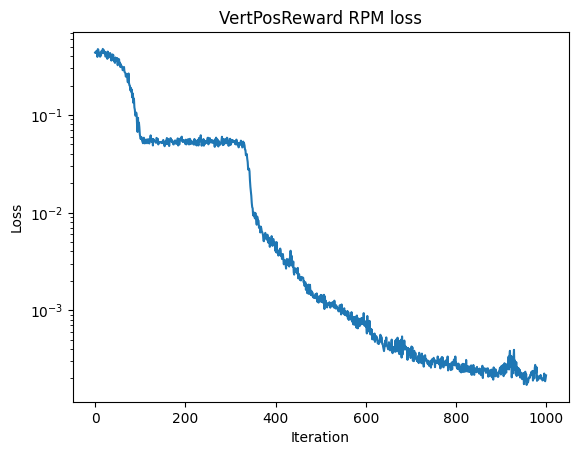

In [9]:
# Visualize the losses
plt.plot(losses)

plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('VertPosReward RPM loss')
plt.yscale('log')
plt.show()

In [10]:
torch.save(model_vertical.state_dict(), 'models/vertpos_RPM_1e-3_1K.pth')

### train ImageDecoder with trained RPM

In [11]:
model_vertical.load_state_dict(torch.load('models/vertpos_RPM_1e-3_1K.pth'))

<All keys matched successfully>

In [12]:
losses_decoder = train_decoder(model_vertical, decoder_vertical, training_data, device, n_iter)

[INFO] Train decoder on device: cuda ...


 10%|█         | 100/1000 [00:46<06:55,  2.17it/s]

[100 / 1000] Reproduction loss: 0.757209837436676


 20%|██        | 200/1000 [01:32<05:42,  2.34it/s]

[200 / 1000] Reproduction loss: 0.08283104002475739


 30%|███       | 300/1000 [02:16<04:44,  2.46it/s]

[300 / 1000] Reproduction loss: 0.05697257071733475


 40%|████      | 400/1000 [02:59<04:15,  2.35it/s]

[400 / 1000] Reproduction loss: 0.05453263223171234


 50%|█████     | 500/1000 [03:42<04:03,  2.05it/s]

[500 / 1000] Reproduction loss: 0.05356733873486519


 60%|██████    | 600/1000 [04:25<02:40,  2.49it/s]

[600 / 1000] Reproduction loss: 0.053178075700998306


 70%|███████   | 700/1000 [05:08<02:10,  2.30it/s]

[700 / 1000] Reproduction loss: 0.05307835340499878


 80%|████████  | 800/1000 [05:52<01:26,  2.32it/s]

[800 / 1000] Reproduction loss: 0.05289110541343689


 90%|█████████ | 900/1000 [06:34<00:41,  2.40it/s]

[900 / 1000] Reproduction loss: 0.052795641124248505


100%|██████████| 1000/1000 [07:18<00:00,  2.28it/s]

[1000 / 1000] Reproduction loss: 0.05280081555247307


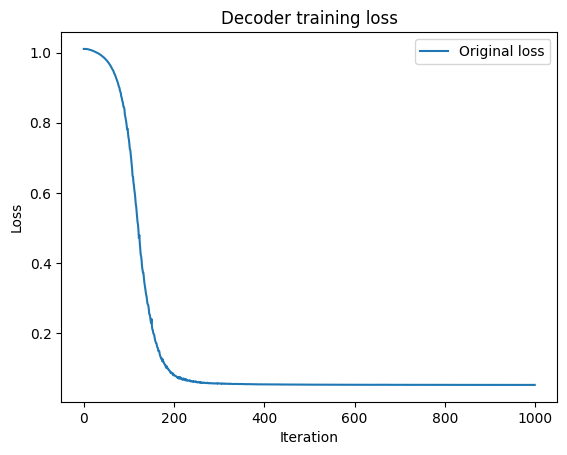

In [13]:
# Visualize the losses
plt.plot(losses_decoder, label='Original loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Decoder training loss')
plt.legend()
plt.show()

In [14]:
DECODER_PATH = 'models/vertpos_decoder_mlp_mseloss_1e-3_1K.pth'
torch.save(decoder_vertical.state_dict(), DECODER_PATH)

## Test Vertical Position Reward finetuned RPM with detached decoder

In [25]:
dataset = MovingSpriteDataset(spec)
eval_data = DataLoader(dataset, batch_size=1)

data = next(iter(eval_data))
images = data['images'].to(device)

with torch.no_grad():
    reconstructed_images = decoder_vertical(model_vertical(images)[0])
reconstructed_images = ( reconstructed_images.cpu().numpy() + 1 ) * (255.0 / 2)

print(f'reconstructed images shape: {reconstructed_images.shape}, \
        max: {reconstructed_images.max()}, min: {reconstructed_images.min()}')

reconstructed_images = make_image_seq_strip([reconstructed_images.astype(np.float32)], sep_val=255.0).astype(np.uint8)
cv2.imwrite('imgs/vertical_decoded.png', reconstructed_images[0].transpose(1, 2, 0))

reconstructed images shape: (1, 29, 3, 64, 64),         max: 16.200286865234375, min: -7.732129096984863


True

### Decode horizontal reward-induced representations with ImageDecoder

In [16]:
model_horizontal = RewardPredictorModel(image_shape, n_frames, T_future).to(device)
decoder_horizontal = ImageDecoder(in_size=64, out_size=64).to(device)

In [17]:
losses = train_RPM_single_reward(model_horizontal, training_data, device, ['horizontal_position'])

[INFO] Training RPM with ['horizontal_position'] reward on device: cuda ...


 10%|█         | 100/1000 [00:43<06:14,  2.40it/s]

[100 / 1000] RPM loss: 0.052905868738889694


 20%|██        | 200/1000 [01:26<05:56,  2.25it/s]

[200 / 1000] RPM loss: 0.05283172428607941


 30%|███       | 300/1000 [02:10<05:09,  2.26it/s]

[300 / 1000] RPM loss: 0.00139992730692029


 40%|████      | 400/1000 [02:55<04:18,  2.32it/s]

[400 / 1000] RPM loss: 0.0005272831185720861


 50%|█████     | 500/1000 [03:38<03:29,  2.39it/s]

[500 / 1000] RPM loss: 0.0003061908355448395


 60%|██████    | 600/1000 [04:22<03:04,  2.17it/s]

[600 / 1000] RPM loss: 0.00019270199118182063


 70%|███████   | 700/1000 [05:06<02:10,  2.29it/s]

[700 / 1000] RPM loss: 0.0001803020277293399


 80%|████████  | 800/1000 [05:50<01:25,  2.33it/s]

[800 / 1000] RPM loss: 0.00014585285680368543


 90%|█████████ | 900/1000 [06:33<00:43,  2.31it/s]

[900 / 1000] RPM loss: 0.00017075634968932718


100%|██████████| 1000/1000 [07:19<00:00,  2.28it/s]

[1000 / 1000] RPM loss: 0.00011408769933041185


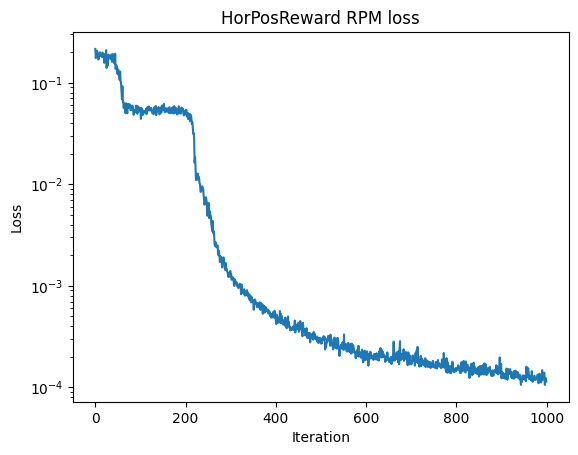

In [18]:
# Visualize the losses
plt.plot(losses)

plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('HorPosReward RPM loss')
plt.yscale('log')
plt.show()

In [19]:
torch.save(model_horizontal.state_dict(), 'models/horpos_RPM_1e-3_1K.pth')

In [20]:
losses_decoder = train_decoder(model_horizontal, decoder_horizontal, training_data, device, n_iter)

[INFO] Train decoder on device: cuda ...


 10%|█         | 100/1000 [00:42<06:10,  2.43it/s]

[100 / 1000] Reproduction loss: 0.8303998112678528


 20%|██        | 200/1000 [01:26<06:37,  2.01it/s]

[200 / 1000] Reproduction loss: 0.11174746602773666


 30%|███       | 300/1000 [02:08<04:58,  2.34it/s]

[300 / 1000] Reproduction loss: 0.057365693151950836


 40%|████      | 400/1000 [02:51<04:10,  2.40it/s]

[400 / 1000] Reproduction loss: 0.05426536872982979


 50%|█████     | 500/1000 [03:31<02:34,  3.24it/s]

[500 / 1000] Reproduction loss: 0.053677044808864594


 60%|██████    | 600/1000 [04:14<03:02,  2.19it/s]

[600 / 1000] Reproduction loss: 0.05332613363862038


 70%|███████   | 700/1000 [04:59<02:18,  2.17it/s]

[700 / 1000] Reproduction loss: 0.05322568118572235


 80%|████████  | 800/1000 [05:44<01:25,  2.34it/s]

[800 / 1000] Reproduction loss: 0.05301666259765625


 90%|█████████ | 900/1000 [06:29<00:42,  2.34it/s]

[900 / 1000] Reproduction loss: 0.05292675271630287


100%|██████████| 1000/1000 [07:14<00:00,  2.30it/s]

[1000 / 1000] Reproduction loss: 0.05282549932599068


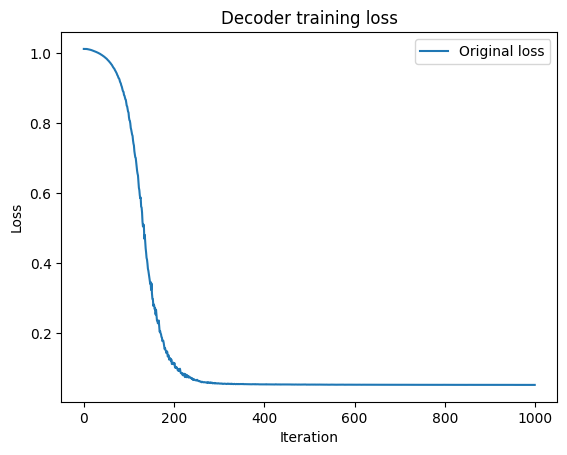

In [21]:
# Visualize the losses
plt.plot(losses_decoder, label='Original loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Decoder training loss')
plt.legend()
plt.show()

In [22]:
DECODER_PATH = 'models/horpos_decoder_mlp_mseloss_1e-3_1K.pth'
torch.save(decoder_horizontal.state_dict(), DECODER_PATH)

In [26]:
dataset = MovingSpriteDataset(spec)
eval_data = DataLoader(dataset, batch_size=1)

data = next(iter(eval_data))
images = data['images'].to(device)

with torch.no_grad():
    reconstructed_images = decoder_horizontal(model_horizontal(images)[0])
reconstructed_images = ( reconstructed_images.cpu().numpy() + 1 ) * (255.0 / 2)

print(f'reconstructed images shape: {reconstructed_images.shape}, \
        max: {reconstructed_images.max()}, min: {reconstructed_images.min()}')

reconstructed_images = make_image_seq_strip([reconstructed_images.astype(np.float32)], sep_val=255.0).astype(np.uint8)
cv2.imwrite('imgs/horizontal_decoded.png', reconstructed_images[0].transpose(1, 2, 0))

reconstructed images shape: (1, 29, 3, 64, 64),         max: 13.175997734069824, min: -13.514582633972168


True